## Importing Necessary Modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Any

## Adding Paths

In [2]:
import os
from pathlib import Path

image_path = Path("../../data/")
print(os.listdir(image_path))

['1. Original Images', '2. All Segmentation Groundtruths', 'CC-BY-4.0.txt', 'LICENSE.txt']


In [3]:
X_train_dir = Path(image_path / "1. Original Images/a. Training Set")
y_train_dir = Path(image_path / "2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages")
X_test_dir = Path(image_path / "1. Original Images/b. Testing Set")
y_test_dir = Path(image_path / "2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages")

print(os.listdir(X_train_dir)[:5])
print(os.listdir(y_train_dir)[:5])
print(os.listdir(X_test_dir)[:5])
print(os.listdir(y_test_dir)[:5])

['IDRiD_01.jpg', 'IDRiD_02.jpg', 'IDRiD_03.jpg', 'IDRiD_04.jpg', 'IDRiD_05.jpg']
['IDRiD_01_HE.tif', 'IDRiD_02_HE.tif', 'IDRiD_03_HE.tif', 'IDRiD_04_HE.tif', 'IDRiD_05_HE.tif']
['IDRiD_55.jpg', 'IDRiD_56.jpg', 'IDRiD_57.jpg', 'IDRiD_58.jpg', 'IDRiD_59.jpg']
['IDRiD_55_HE.tif', 'IDRiD_56_HE.tif', 'IDRiD_57_HE.tif', 'IDRiD_58_HE.tif', 'IDRiD_59_HE.tif']


### Training Image

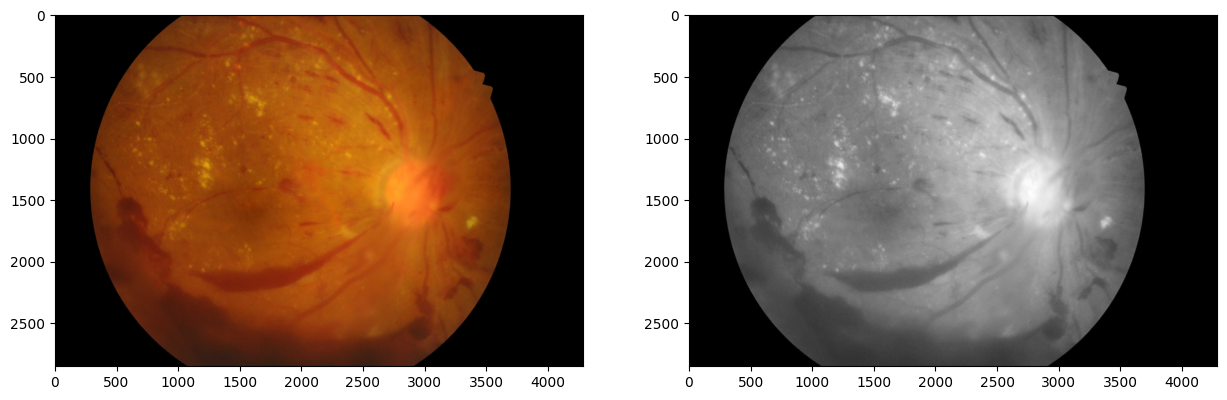

In [4]:
from PIL import Image, ImageOps

img = Image.open(Path(X_train_dir / os.listdir(X_train_dir)[16]))
img_grayed = ImageOps.grayscale(img)

numpy_img = np.asarray(img)
numpy_img_grayed = np.asarray(img_grayed)

plt.rcParams['figure.figsize'] = [15, 15]
fig, axis = plt.subplots(1, 2)
axis[0].imshow(numpy_img)
axis[1].imshow(numpy_img_grayed, cmap="gray")

### Training Image Mask

1 0


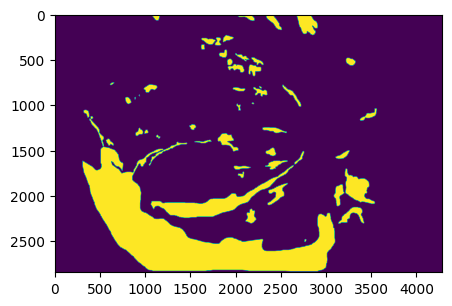

In [5]:
img_mask = Image.open(Path(y_train_dir  / "IDRiD_17_HE.tif"))

numpy_img = np.asarray(img_mask)

plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(numpy_img)
print(np.max(numpy_img), np.min(numpy_img))

## Loading Dataset

In [6]:
img_height = 256
img_width = 256

In [7]:
def preprocess_input(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.random_brightness(image, 0.2)
    #image = tf.image.random_hue(image, 0.1)
    image = (image / 255.0)
    return image

# --------------------------------------------X train dataset--------------------------------------------------#
X_train = tf.keras.preprocessing.image_dataset_from_directory(
    X_train_dir,
    labels=None,
    batch_size=1,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    shuffle=False,
    interpolation='nearest',)
X_train = X_train.map(lambda x: (preprocess_input(x)))

# --------------------------------------------y train dataset--------------------------------------------------#
y_train_list = []
for images in os.listdir(y_train_dir):
    img = Image.open(Path(y_train_dir / images)).resize((img_width, img_height), resample=Image.NEAREST)
    img_arr = np.expand_dims(np.array(img, dtype="float32"), axis=-1)
    y_train_list.append(img_arr)
y_train_list = np.expand_dims(y_train_list, axis=1)
y_train = tf.data.Dataset.from_tensor_slices(y_train_list)
#y_train = tf.convert_to_tensor(y_train_list, dtype=tf.float32)
#y_train = y_train.map(lambda x: preprocess_input(x))

# --------------------------------------------X test dataset---------------------------------------------------#
X_test = tf.keras.preprocessing.image_dataset_from_directory(
    X_test_dir,
    labels=None,
    batch_size=1,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    shuffle=False,
    interpolation='nearest',)
X_test = X_test.map(lambda x: (preprocess_input(x)))

# --------------------------------------------y test dataset---------------------------------------------------#
y_test_list = []
for images in os.listdir(y_test_dir):
    img = Image.open(Path(y_test_dir / images)).resize((img_width, img_height), resample=Image.NEAREST)
    img_arr = np.expand_dims(np.array(img, dtype="float32"), axis=-1)
    y_test_list.append(img_arr)
y_test_list = np.expand_dims(y_train_list, axis=1)
y_test = tf.data.Dataset.from_tensor_slices(y_test_list)
#y_test = tf.convert_to_tensor(y_test_list, dtype=tf.float32)
#y_test = y_test.map(lambda x: preprocess_input(x))

train_dataset = tf.data.Dataset.zip((X_train, y_train))
test_dataset = tf.data.Dataset.zip((X_test, y_test))

Found 54 files belonging to 1 classes.
Found 27 files belonging to 1 classes.


<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(1, 256, 256, 1), dtype=tf.float32, name=None))>
(1, 256, 256, 1) (1, 256, 256, 1)
(256, 256, 1) (256, 256, 1)


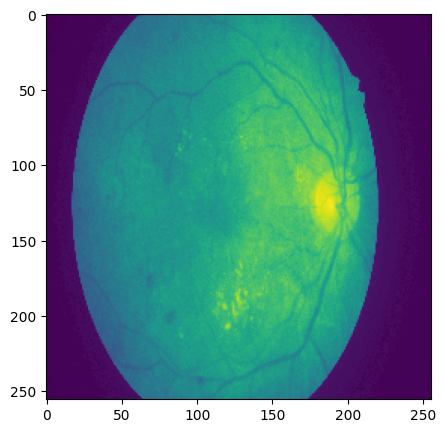

In [8]:
inp = train_dataset.take(1)
print(inp)
for i, j in inp:
    print(i.shape, j.shape)
    print(i[0, :, :, :].shape, j[0, :, :, :].shape)
    plt.imshow(i[0, :, :, :])
    #plt.imshow(j[0, :, : ,:])

## U-Net Model

In [9]:
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Input, Concatenate, Dropout, BatchNormalization, Activation, Dense


def conv_block(inp, filters):
    conv = Conv2D(filters, 3, padding='same')(inp)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)

    conv = Conv2D(filters, 3, padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv


def encoder_layer(inp: Any, filters:int):
    enc = conv_block(inp, filters)
    enc_pool = MaxPool2D((2, 2))(enc)
    return enc, enc_pool


def decoder_layer(inp:Any, skip_connections:Any, filters:int) -> Any:
    dec = Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(inp)
    dec = Concatenate()([dec, skip_connections])
    dec = conv_block(dec, filters)
    return dec

In [10]:
def UNet(input_shape):
    inputs = Input(input_shape)
    print("Inputs:", inputs)

    ds1, dp1 = encoder_layer(inputs, 64) # downsampling layer1 → → → → → → → → →
                                         #   ↓                                 ↓
    ds2, dp2 = encoder_layer(dp1, 128)   # downsampling layer2 → → → → → → →   ↓  
                                         #   ↓                             ↓   ↓
    ds3, dp3 = encoder_layer(dp2, 256)   # downsampling layer3 → → → → →   ↓   ↓ 
                                         #   ↓                         ↓   ↓   ↓
    ds4, dp4 = encoder_layer(dp3, 512)   # downsampling layer4 → → →   ↓   ↓   ↓
                                         #   ↓                     ↓   ↓   ↓   ↓
    bc = conv_block(dp4, 1024)           # bridge connect layer    ↓   ↓   ↓   ↓
                                         #   ↓                     ↓   ↓   ↓   ↓
    us1 = decoder_layer(bc, ds4, 512)    # upsampling layer1 ← ← ← ←   ↓   ↓   ↓
                                         #   ↓                         ↓   ↓   ↓
    us2 = decoder_layer(us1, ds3, 256)   # upsampling layer2 ← ← ← ← ← ←   ↓   ↓
                                         #   ↓                             ↓   ↓
    us3 = decoder_layer(us2, ds2, 128)   # upsampling layer3 ← ← ← ← ← ← ← ←   ↓    
                                         #   ↓                                 ↓
    us4 = decoder_layer(us3, ds1, 64)    # upsampling layer4 ← ← ← ← ← ← ← ← ← ←


    output = Conv2D(1, 1, padding="same", activation="sigmoid")(us4)

    model = Model(inputs, output, name="UNet")

    return model

In [11]:
from helpers.helper import TfMetrics, NpMetrics
from keras.optimizers import Adam

metrics = TfMetrics()
model = UNet([img_height, img_width, 1])
model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss=metrics.iou_loss,
              metrics=[metrics.iou])
model.summary()

Inputs: KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  

In [50]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
batch_size = 8
model.fit(train_dataset, batch_size=batch_size, epochs=10)

Epoch 1/10
53/53 [==============================] - 13s 233ms/step - loss: 0.9602 - iou: 0.0398
Epoch 2/10
53/53 [==============================] - 12s 234ms/step - loss: 0.9561 - iou: 0.0439
Epoch 3/10
53/53 [==============================] - 12s 225ms/step - loss: 0.9533 - iou: 0.0467
Epoch 4/10
53/53 [==============================] - 10s 179ms/step - loss: 0.9506 - iou: 0.0494
Epoch 5/10
53/53 [==============================] - 10s 180ms/step - loss: 0.9489 - iou: 0.0511
Epoch 6/10
53/53 [==============================] - 10s 181ms/step - loss: 0.9455 - iou: 0.0545
Epoch 7/10
53/53 [==============================] - 10s 182ms/step - loss: 0.9462 - iou: 0.0538
Epoch 8/10
53/53 [==============================] - 10s 183ms/step - loss: 0.9462 - iou: 0.0538
Epoch 9/10
53/53 [==============================] - 10s 183ms/step - loss: 0.9296 - iou: 0.0704
Epoch 10/10
53/53 [==============================] - 10s 183ms/step - loss: 0.9444 - iou: 0.0556


27/27 [==============================] - 2s 63ms/step
[256 256   1]


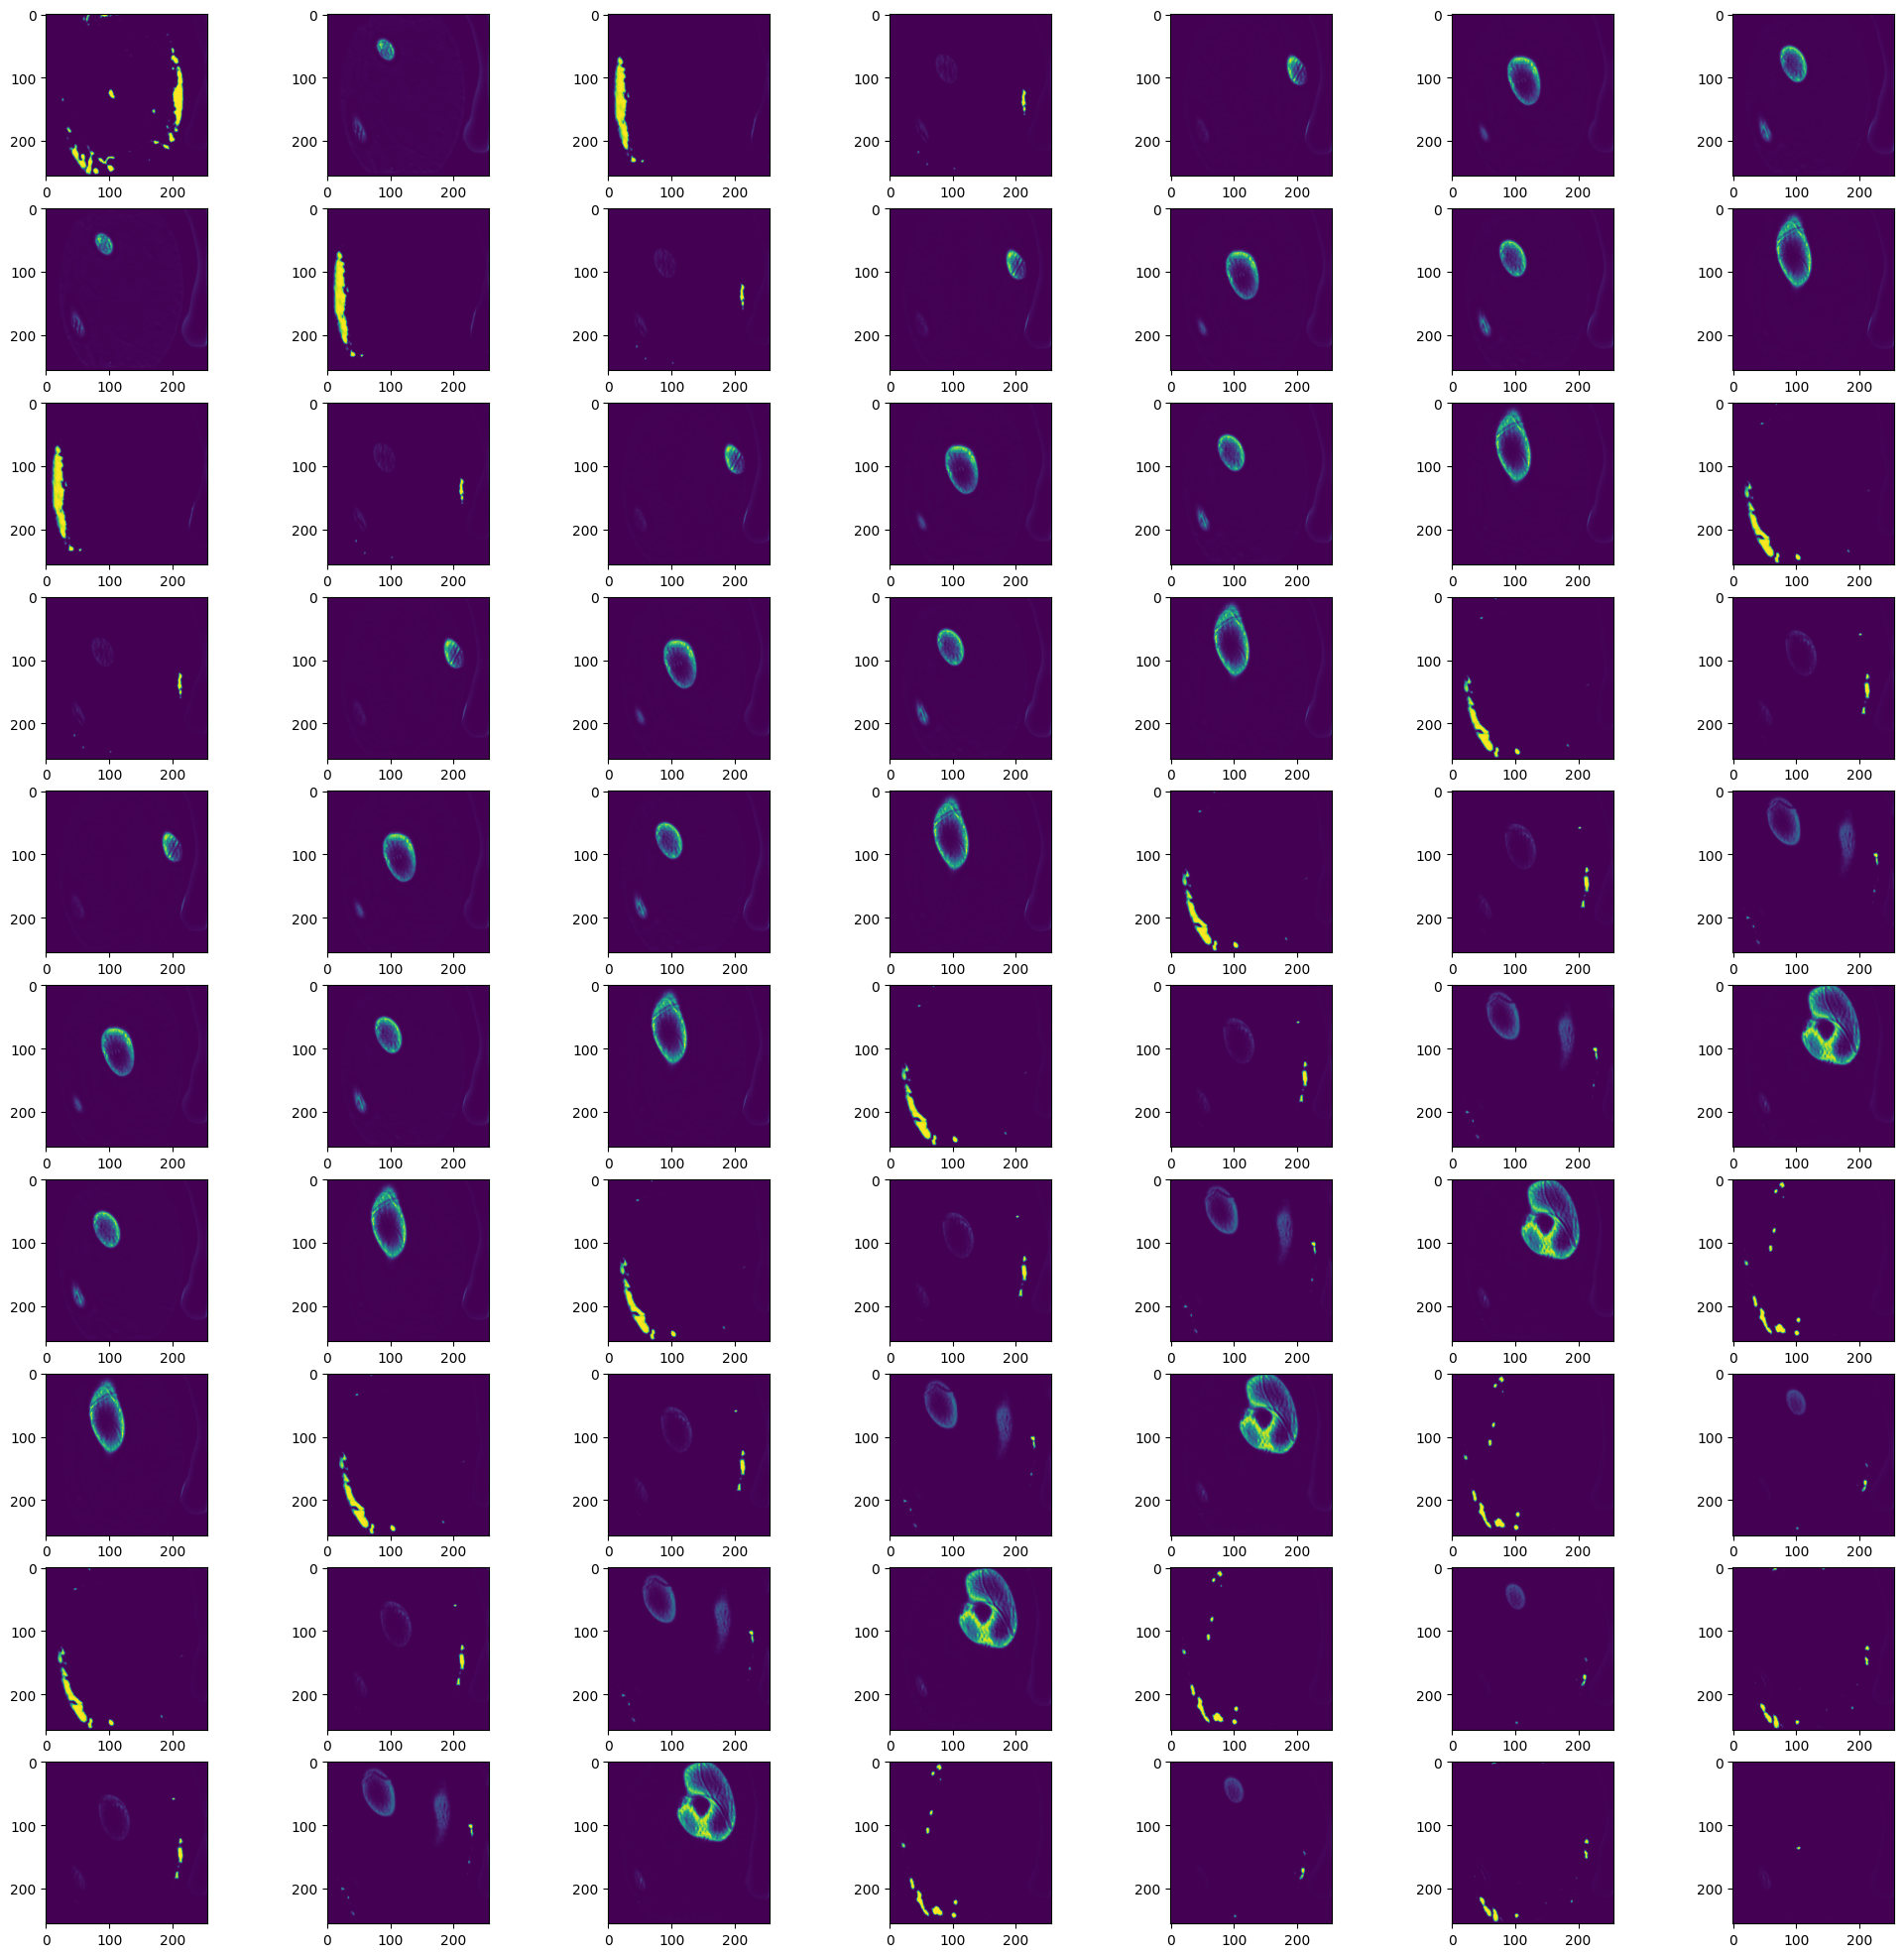

In [28]:
rows, cols = 10, 7
img = model.predict(test_dataset)
print(np.array(img[0, :, :, :,].shape))

plt.rcParams['figure.figsize'] = [25, 25]
fig, axis = plt.subplots(rows, cols)
for i in range(rows):
    for j in range(cols):
        axis[i][j].imshow(img[i + j])

In [29]:
len(img)

27

In [38]:
img_no = 1

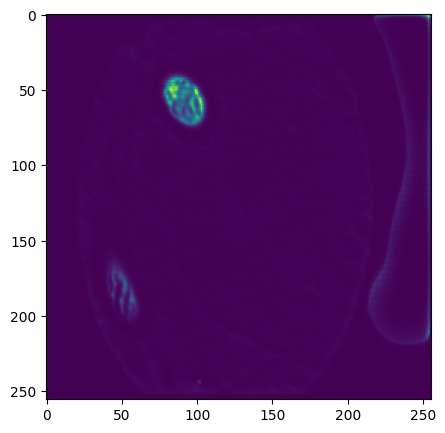

In [39]:
y_pred = img[img_no]
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(y_pred)

In [42]:
truth = test_dataset.take(img_no+1)
x_truth_vals, y_truth_vals = [], []
for vals in truth:
    x_true, y_true = vals
    x_truth_vals.append(x_true)
    y_truth_vals.append(y_true)

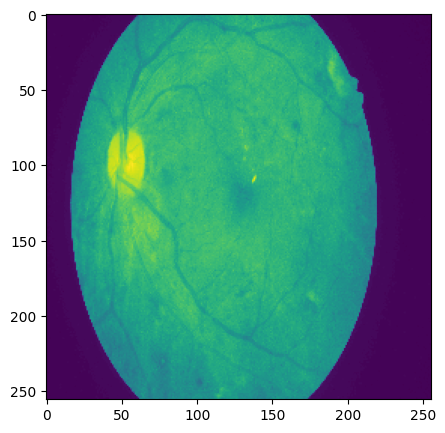

In [43]:
plt.imshow(x_truth_vals[img_no][0, :, :, :])

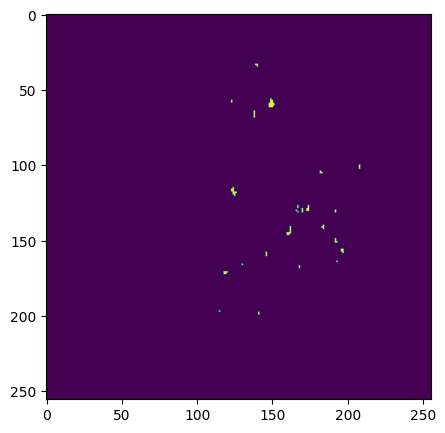

In [44]:
plt.imshow(y_truth_vals[img_no][0, 0, :, :, :])

In [45]:
npmetrics = NpMetrics(y_truth_vals[img_no][0, 0, :, :, :].numpy(), x_truth_vals[img_no][0, :, :, :].numpy())
print("IOU Accuracy:", npmetrics.iou())

IOU Accuracy: 0.0021116375


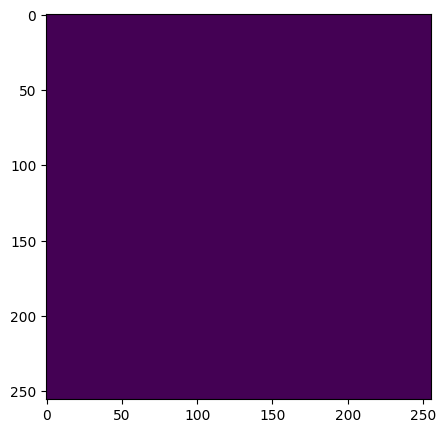

In [46]:
maximum = np.max(img[img_no])
minimum = np.min(img[img_no])
mask = (img[img_no] > 0.9).astype(float)
plt.imshow(mask)